# Coin Seminar Plant Sleep Quality Regression

## Preparation

First of all the required packages need to be installed.

In [ ]:
!pip install timm librosa torch torchvision

Afterwards we will import all the required packages.

In [ ]:
import random

import pandas as pd
import numpy as np
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from PIL import Image
import torchaudio
from transformers import ASTFeatureExtractor

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

from google.colab import drive

In [ ]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

The notebook will be mounted to google drive to ensure persistent files for all sessions.

In [ ]:
drive.mount("./Drive")

Mounted at ./Drive


We will then select the directory, where all plant recordings and labels are saved.

In [ ]:
%cd /content/Drive/MyDrive/Seminar COINs/COIN Projekt

/content/Drive/MyDrive/Seminar COINs/COIN Projekt


### Helper functions

We will use the following helper function to load and preprocess the audio data. The function will create a tuple of arrays containing the Mel Frequency Cepstral Coefficients, the values for the MEL Spectrograms, the filenames, and the associated subset.

In [ ]:
# Load and preprocess audio data
def load_and_preprocess_data(data_dir, subsets, hop_length=512, n_mels=128):
    """Loads and preprocesses audio data from specified directories.

    Args:
      data_dir: The directory containing the audio data.
      subsets: A list of subdirectories within `data_dir` to load data from.
      hop_length: The hop length to use when computing the Mel spectrogram.
      n_mels: The number of Mel frequency bins to use.

    Returns:
      A tuple containing:
        - A list of Mel spectrograms, one for each audio file.
        - A NumPy array of filenames corresponding to the Mel spectrograms.
        - A list of MFCCs, one for each audio file.
        - A list of subset names corresponding to the Mel spectrograms.
    """
    data = []
    filenames = []
    signals = []
    subset_names = []
    audio_dir = data_dir
    # We iterate through each subset
    for i, subset in enumerate(subsets):
      subset_dir = os.path.join(audio_dir, subset)
      for filename in os.listdir(subset_dir):
        try:
          if filename.endswith('.wav'):
              file_path = os.path.join(subset_dir, filename) # joining the path to the subset and the filename to get the full path
              print(file_path)
              audio_data, sample_rate = librosa.load(file_path, sr=None) # We load the audio data with librosa
              # Perform preprocessing (e.g., convert to Mel spectrogram)
              audio_signal = librosa.feature.mfcc(y=audio_data, sr=sample_rate) # Extracting Mel Frequency Cepstral Coefficients
              mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=n_mels, hop_length=hop_length) # Extracting  Mel spectrogram
              mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) # We convert the amplitudes to decibel scale
              filenames.append(filename) # Saving the filenames in case we need it later
              subset_names.append(subset)
              signals.append(audio_signal)
              data.append(mel_spectrogram)
        except:
          pass
    return data, np.array(filenames), signals, subset_names

## Loading the data

We will load the labels separately as a Dataframe from the sleep circle data export. It is important to note that the datetime columns "Went to bed" and "Woke up" need to be converted to the datetime with the '%Y-%m-%d %H' format.

In [ ]:
sleep_circle_dir = "./data/Labels/"
sleep_circle_dir

'./data/Labels/'

In [ ]:
sleep_circle_data_list = []
for filename in os.listdir("./data/Labels/"):
  sleep__circle_data = pd.read_csv(os.path.join(sleep_circle_dir, filename), delimiter= ";")
  sleep__circle_data.rename(columns={"Start": "Went to bed", "End": "Woke up"}, inplace = True)
  sleep__circle_data["Went to bed"] = pd.to_datetime(pd.to_datetime(sleep__circle_data["Went to bed"]).dt.strftime('%Y-%m-%d %H'))
  sleep__circle_data["Woke up"] =  pd.to_datetime(pd.to_datetime(sleep__circle_data["Woke up"]).dt.strftime('%Y-%m-%d %H'))
  sleep__circle_data["subset_name"] = filename.split(".csv")[0]
  sleep_circle_data_list.append(sleep__circle_data)
sleep_circle_df = pd.concat(sleep_circle_data_list)
sleep_circle_df

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Steps,Alarm mode,Air Pressure (Pa),Time before sleep (seconds),Window start,Window stop,Snore time,Weather temperature (°C),Weather type,Notes
0,2024-10-16 03:00:00,2024-10-16 11:00:00,81%,28537.0,25302.0,570.0,—,False,0.0,0.630760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-18 03:00:00,2024-10-18 11:00:00,76%,26734.0,22278.0,1247.0,96%,False,0.0,0.807960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-19 03:00:00,2024-10-19 11:00:00,99%,29337.0,24154.0,586.0,95%,False,0.0,0.613560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-20 03:00:00,2024-10-20 10:00:00,62%,26557.0,22219.0,885.0,94%,False,0.0,0.813345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-21 04:00:00,2024-10-21 11:00:00,55%,27855.0,25626.0,557.0,91%,False,0.0,0.129241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,2024-11-18 23:00:00,2024-11-19 07:00:00,82%,29625.0,26959.0,592.0,92%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2024-11-19 23:00:00,2024-11-20 08:00:00,90%,30010.0,24408.0,600.0,90%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2024-11-20 23:00:00,2024-11-21 08:00:00,89%,31169.0,26493.0,623.0,94%,False,0.0,1.385992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2024-11-21 23:00:00,2024-11-22 08:00:00,94%,31146.0,27720.0,2491.0,93%,False,0.0,0.462339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sleep_circle_df["subset_name"].unique()

array(['behrad', 'linus', 'Jasper', 'Fynn'], dtype=object)

With the helper function we will load and preprocess the plant recordings.

In [ ]:
data_dir = './data/Audio_Data'
subsets = ['behrad', 'linus', 'Jasper', 'Fynn']
audio_files, filenames, signals, subset_names  = load_and_preprocess_data(data_dir = data_dir, subsets = subsets)

./data/Audio_Data/behrad/behrad_142Hz_1731205560774.wav
./data/Audio_Data/behrad/behrad_142Hz_1731030918106.wav
./data/Audio_Data/behrad/behrad_142Hz_1730861279308.wav
./data/Audio_Data/behrad/behrad_142Hz_1731808947165.wav
./data/Audio_Data/behrad/behrad_142Hz_1731721964748.wav
./data/Audio_Data/behrad/behrad_142Hz_1731639615572.wav
./data/Audio_Data/behrad/behrad_142Hz_1731463744547.wav
./data/Audio_Data/behrad/behrad_142Hz_1731894532622.wav
./data/Audio_Data/behrad/behrad_142Hz_1731290866877.wav
./data/Audio_Data/behrad/behrad_142Hz_1731552619742.wav
./data/Audio_Data/behrad/behrad_142Hz_1731375736354.wav
./data/Audio_Data/behrad/behrad_07-11-2024_02_51_09_142Hz_1730944269321.wav
./data/Audio_Data/behrad/behrad_142Hz_1729904937567.wav
./data/Audio_Data/behrad/behrad_142Hz_1729994749595.wav
./data/Audio_Data/behrad/behrad_142Hz_1730169214846.wav
./data/Audio_Data/behrad/behrad_142Hz_1730341004221.wav
./data/Audio_Data/behrad/behrad_142Hz_1730426561089.wav
./data/Audio_Data/behrad/beh

<ipython-input-6-66042333aa69>:31: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None) # We load the audio data with librosa
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


./data/Audio_Data/Fynn/fynn_142Hz_1731103932842.wav
./data/Audio_Data/Fynn/fynn_142Hz_1731193748076.wav
./data/Audio_Data/Fynn/fynn_142Hz_1731276994769.wav
./data/Audio_Data/Fynn/fynn_142Hz_1731350077682.wav
./data/Audio_Data/Fynn/fynn_0Hz_1731400665893.wav
./data/Audio_Data/Fynn/fynn_142Hz_1731448941993.wav


<ipython-input-6-66042333aa69>:31: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None) # We load the audio data with librosa
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


./data/Audio_Data/Fynn/fynn_142Hz_1731534502998.wav
./data/Audio_Data/Fynn/fynn_142Hz_1731708977755.wav
./data/Audio_Data/Fynn/fynn_142Hz_1731795871013.wav
./data/Audio_Data/Fynn/fynn_142Hz_1731883717724.wav
./data/Audio_Data/Fynn/fynn_142Hz_1731968098508.wav
./data/Audio_Data/Fynn/fynn_142Hz_1732056377456.wav
./data/Audio_Data/Fynn/fynn_142Hz_1732143060447.wav
./data/Audio_Data/Fynn/fynn_142Hz_1732228030045.wav
./data/Audio_Data/Fynn/fynn_142Hz_1732487181377.wav


From the filenames we extract the timestamp and convert it to the same format as the "Went to bed" column from the sleep circle data.

In [ ]:
audio_timestamps = []
for filename in filenames:
  timestamp = filename.split("_")[-1]
  timestamp = timestamp.split(".")[0]
  timestamp = int(timestamp)
  timestamp = datetime.utcfromtimestamp(timestamp/1000).strftime('%Y-%m-%d %H')
  audio_timestamps.append(timestamp)

We join the arrays to a single dataframe for easier use.

In [ ]:
audio_df = pd.DataFrame(data = {"timestamp": audio_timestamps, "mel_spectrogram": audio_files, "mfcc": signals, "filenames": filenames, "subset": subset_names})
audio_df['timestamp'] = pd.to_datetime(audio_df['timestamp'])
audio_df

,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-11-10 02:00:00,"[[3.8146973e-06, -1.6108208, -13.502918, -23.9...","[[130.01466, 62.54068, -222.61348, -224.39777,...",behrad_142Hz_1731205560774.wav,behrad
1,2024-11-08 01:00:00,"[[-0.3070526, -1.0558624, -2.5947418, -2.61366...","[[-85.28314, -144.85248, -250.27249, -244.6925...",behrad_142Hz_1731030918106.wav,behrad
2,2024-11-06 02:00:00,"[[0.0, -0.7562885, -2.191145, -2.0556793, -2.1...","[[-87.963745, -145.52043, -236.48051, -239.047...",behrad_142Hz_1730861279308.wav,behrad
3,2024-11-17 02:00:00,"[[-18.497055, -19.105219, -20.147926, -20.6168...","[[-94.037865, -151.36404, -242.62401, -257.627...",behrad_142Hz_1731808947165.wav,behrad
4,2024-11-16 01:00:00,"[[-19.61416, -20.31984, -18.795206, -13.579906...","[[-93.44319, -148.90176, -220.43121, -216.1947...",behrad_142Hz_1731721964748.wav,behrad
...,...,...,...,...,...
71,2024-11-18 22:00:00,"[[-0.0961895, -0.82863426, -2.198948, -2.20227...","[[-79.49539, -139.93092, -260.96878, -265.6299...",fynn_142Hz_1731968098508.wav,Fynn
72,2024-11-19 22:00:00,"[[1.9073486e-06, -0.7373524, -2.1103191, -2.11...","[[-79.455315, -139.61522, -260.65607, -266.821...",fynn_142Hz_1732056377456.wav,Fynn
73,2024-11-20 22:00:00,"[[-2.381443, -3.2180462, -4.5631256, -3.874576...","[[-62.916992, -108.53385, -162.01813, -155.320...",fynn_142Hz_1732143060447.wav,Fynn
74,2024-11-21 22:00:00,"[[1.9073486e-06, -0.7510834, -2.1372318, -2.14...","[[-78.499825, -140.13397, -286.0441, -276.1595...",fynn_142Hz_1732228030045.wav,Fynn


We will sort the sleep circle data and the plant recording data to merge both dataframe with eachother.

In [ ]:
sleep_circle_df = sleep_circle_df.sort_values("Went to bed")

audio_df = audio_df.sort_values('timestamp')

Because the plant recording starting time and the sleep circle timestamp sometimes do not match to the exact hour, we will merge both dataframes on the "Went to bed" column and the "timestamp" column with a range of 3 hours.

In [ ]:
concat_arr = []
for subset in subsets:
  subset_df = audio_df[audio_df["subset"] == subset]
  sleep_circle_subset_df = sleep_circle_df[sleep_circle_df["subset_name"] == subset]
  subset_merged_df = pd.merge_asof(sleep_circle_subset_df, subset_df, left_on="Went to bed", right_on ="timestamp", direction='nearest', tolerance=pd.Timedelta('3 hour'))
  concat_arr.append(subset_merged_df)
merged_df = pd.concat(concat_arr)

We drop all rows which have null values for the mel_spectrogram. Furthermore we convert the sleep quality column to the float data type ranging from 0 to 1.

In [ ]:
merged_df = merged_df.dropna(subset = ["mel_spectrogram"]).reset_index(drop=True)
merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", ""))/100)
#merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", "")))
merged_df

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Window stop,Snore time,Weather temperature (°C),Weather type,Notes,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,28383.0,24504.0,3879.0,93%,False,0.0,0.126836,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.845198, -19.083887, -20.093538, -20.2239...","[[-103.47621, -161.67538, -257.6723, -259.5341...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,26815.0,24312.0,1877.0,90%,False,0.0,0.671266,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.23892, -9.857187, -11.167709, -11.00028, ...","[[-103.45986, -161.75743, -261.34668, -251.597...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,30190.0,25460.0,603.0,83%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.04505, -18.773344, -20.911755, -21.46679...","[[-78.52124, -138.69447, -247.02243, -231.1913...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:00:00,2024-10-29 11:00:00,0.80,28575.0,26098.0,2476.0,91%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 02:00:00,"[[-19.099976, -19.661247, -20.979252, -21.1117...","[[-92.270676, -148.72513, -249.18297, -267.216...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,26133.0,23345.0,522.0,92%,False,0.0,0.688784,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.892347, -19.253256, -20.119987, -18.2465...","[[-114.934906, -160.91049, -212.936, -212.7094...",behrad_142Hz_1730341004221.wav,behrad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2024-11-18 23:00:00,2024-11-19 07:00:00,0.82,29625.0,26959.0,592.0,92%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-11-18 22:00:00,"[[-0.0961895, -0.82863426, -2.198948, -2.20227...","[[-79.49539, -139.93092, -260.96878, -265.6299...",fynn_142Hz_1731968098508.wav,Fynn
69,2024-11-19 23:00:00,2024-11-20 08:00:00,0.90,30010.0,24408.0,600.0,90%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-11-19 22:00:00,"[[1.9073486e-06, -0.7373524, -2.1103191, -2.11...","[[-79.455315, -139.61522, -260.65607, -266.821...",fynn_142Hz_1732056377456.wav,Fynn
70,2024-11-20 23:00:00,2024-11-21 08:00:00,0.89,31169.0,26493.0,623.0,94%,False,0.0,1.385992,...,NaN,NaN,NaN,NaN,NaN,2024-11-20 22:00:00,"[[-2.381443, -3.2180462, -4.5631256, -3.874576...","[[-62.916992, -108.53385, -162.01813, -155.320...",fynn_142Hz_1732143060447.wav,Fynn
71,2024-11-21 23:00:00,2024-11-22 08:00:00,0.94,31146.0,27720.0,2491.0,93%,False,0.0,0.462339,...,NaN,NaN,NaN,NaN,NaN,2024-11-21 22:00:00,"[[1.9073486e-06, -0.7510834, -2.1372318, -2.14...","[[-78.499825, -140.13397, -286.0441, -276.1595...",fynn_142Hz_1732228030045.wav,Fynn


In [ ]:
merged_df[merged_df["subset"]== "behrad"]

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Window stop,Snore time,Weather temperature (°C),Weather type,Notes,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,28383.0,24504.0,3879.0,93%,False,0.0,0.126836,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.845198, -19.083887, -20.093538, -20.2239...","[[-103.47621, -161.67538, -257.6723, -259.5341...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,26815.0,24312.0,1877.0,90%,False,0.0,0.671266,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.23892, -9.857187, -11.167709, -11.00028, ...","[[-103.45986, -161.75743, -261.34668, -251.597...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,30190.0,25460.0,603.0,83%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.04505, -18.773344, -20.911755, -21.46679...","[[-78.52124, -138.69447, -247.02243, -231.1913...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:00:00,2024-10-29 11:00:00,0.80,28575.0,26098.0,2476.0,91%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 02:00:00,"[[-19.099976, -19.661247, -20.979252, -21.1117...","[[-92.270676, -148.72513, -249.18297, -267.216...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,26133.0,23345.0,522.0,92%,False,0.0,0.688784,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.892347, -19.253256, -20.119987, -18.2465...","[[-114.934906, -160.91049, -212.936, -212.7094...",behrad_142Hz_1730341004221.wav,behrad
5,2024-11-01 03:00:00,2024-11-01 09:00:00,0.61,22321.0,17856.0,446.0,90%,False,0.0,0.322566,...,NaN,NaN,NaN,NaN,NaN,2024-11-01 02:00:00,"[[-17.101957, -18.444462, -19.50819, -18.74341...","[[-88.19196, -137.61987, -199.88036, -203.2072...",behrad_142Hz_1730426561089.wav,behrad
6,2024-11-02 03:00:00,2024-11-02 11:00:00,0.66,27411.0,23756.0,548.0,91%,False,0.0,0.788005,...,NaN,NaN,NaN,NaN,NaN,2024-11-02 02:00:00,"[[-21.891184, -20.23951, -19.505045, -17.7669,...","[[-158.68939, -183.98936, -197.84569, -199.374...",behrad_142Hz_1730513248148.wav,behrad
7,2024-11-03 03:00:00,2024-11-03 09:00:00,0.66,23343.0,19297.0,1478.0,90%,False,0.0,0.154222,...,NaN,NaN,NaN,NaN,NaN,2024-11-03 01:00:00,"[[3.8146973e-06, -2.5599136, -6.285042, -8.977...","[[44.803688, -21.663483, -205.35748, -238.6216...",behrad_142Hz_1730598993365.wav,behrad
8,2024-11-05 02:00:00,2024-11-05 11:00:00,0.84,31618.0,27929.0,1686.0,86%,False,0.0,0.455437,...,NaN,NaN,NaN,NaN,NaN,2024-11-05 01:00:00,"[[-0.2188549, -0.99575424, -2.3791656, -2.3756...","[[-86.27451, -144.0646, -235.64586, -238.1038,...",behrad_142Hz_1730770930651.wav,behrad
9,2024-11-06 03:00:00,2024-11-06 08:00:00,0.53,17813.0,14903.0,1543.0,74%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-11-06 02:00:00,"[[0.0, -0.7562885, -2.191145, -2.0556793, -2.1...","[[-87.963745, -145.52043, -236.48051, -239.047...",behrad_142Hz_1730861279308.wav,behrad


In [ ]:
merged_df[merged_df["subset"]== "behrad"]

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Window stop,Snore time,Weather temperature (°C),Weather type,Notes,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,28383.0,24504.0,3879.0,93%,False,0.0,0.126836,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.845198, -19.083887, -20.093538, -20.2239...","[[-103.47621, -161.67538, -257.6723, -259.5341...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,26815.0,24312.0,1877.0,90%,False,0.0,0.671266,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.23892, -9.857187, -11.167709, -11.00028, ...","[[-103.45986, -161.75743, -261.34668, -251.597...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,30190.0,25460.0,603.0,83%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.04505, -18.773344, -20.911755, -21.46679...","[[-78.52124, -138.69447, -247.02243, -231.1913...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:00:00,2024-10-29 11:00:00,0.80,28575.0,26098.0,2476.0,91%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 02:00:00,"[[-19.099976, -19.661247, -20.979252, -21.1117...","[[-92.270676, -148.72513, -249.18297, -267.216...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,26133.0,23345.0,522.0,92%,False,0.0,0.688784,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.892347, -19.253256, -20.119987, -18.2465...","[[-114.934906, -160.91049, -212.936, -212.7094...",behrad_142Hz_1730341004221.wav,behrad
5,2024-11-01 03:00:00,2024-11-01 09:00:00,0.61,22321.0,17856.0,446.0,90%,False,0.0,0.322566,...,NaN,NaN,NaN,NaN,NaN,2024-11-01 02:00:00,"[[-17.101957, -18.444462, -19.50819, -18.74341...","[[-88.19196, -137.61987, -199.88036, -203.2072...",behrad_142Hz_1730426561089.wav,behrad
6,2024-11-02 03:00:00,2024-11-02 11:00:00,0.66,27411.0,23756.0,548.0,91%,False,0.0,0.788005,...,NaN,NaN,NaN,NaN,NaN,2024-11-02 02:00:00,"[[-21.891184, -20.23951, -19.505045, -17.7669,...","[[-158.68939, -183.98936, -197.84569, -199.374...",behrad_142Hz_1730513248148.wav,behrad
7,2024-11-03 03:00:00,2024-11-03 09:00:00,0.66,23343.0,19297.0,1478.0,90%,False,0.0,0.154222,...,NaN,NaN,NaN,NaN,NaN,2024-11-03 01:00:00,"[[3.8146973e-06, -2.5599136, -6.285042, -8.977...","[[44.803688, -21.663483, -205.35748, -238.6216...",behrad_142Hz_1730598993365.wav,behrad
8,2024-11-05 02:00:00,2024-11-05 11:00:00,0.84,31618.0,27929.0,1686.0,86%,False,0.0,0.455437,...,NaN,NaN,NaN,NaN,NaN,2024-11-05 01:00:00,"[[-0.2188549, -0.99575424, -2.3791656, -2.3756...","[[-86.27451, -144.0646, -235.64586, -238.1038,...",behrad_142Hz_1730770930651.wav,behrad
9,2024-11-06 03:00:00,2024-11-06 08:00:00,0.53,17813.0,14903.0,1543.0,74%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-11-06 02:00:00,"[[0.0, -0.7562885, -2.191145, -2.0556793, -2.1...","[[-87.963745, -145.52043, -236.48051, -239.047...",behrad_142Hz_1730861279308.wav,behrad


In [ ]:
merged_df[merged_df["subset"]== "linus"]

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Window stop,Snore time,Weather temperature (°C),Weather type,Notes,timestamp,mel_spectrogram,mfcc,filenames,subset
21,2024-10-24 00:00:00,2024-10-24 08:00:00,0.86,28483.7,24875.8,NaN,91%,True,NaN,NaN,...,2024-10-24 08:30:00,445.6,0.0,No weather,NaN,2024-10-23 22:00:00,"[[1.9073486e-06, -0.7811718, -2.1136894, -2.04...","[[-76.456566, -123.06618, -205.4203, -195.6450...",linus_142Hz_1729721787072.wav,linus
22,2024-10-29 01:00:00,2024-10-29 08:00:00,0.68,22502.7,19502.4,NaN,0%,True,NaN,NaN,...,NaN,1020.2,0.0,No weather,NaN,2024-10-29 00:00:00,"[[1.9073486e-06, -0.7155781, -1.9218235, -1.82...","[[-84.16643, -116.547066, -160.67404, -200.980...",linus_142Hz_1730163250153.wav,linus
23,2024-10-30 00:00:00,2024-10-30 07:00:00,0.78,25513.1,21175.9,NaN,84%,True,NaN,NaN,...,NaN,930.0,0.0,No weather,NaN,2024-10-29 23:00:00,"[[-1.3402023, -2.0798512, -3.4581966, -3.50234...","[[-76.878784, -120.77661, -177.9117, -171.7848...",linus_142Hz_1730244394101.wav,linus
24,2024-10-31 00:00:00,2024-10-31 09:00:00,0.97,32069.1,25869.1,NaN,84%,True,NaN,NaN,...,2024-10-31 09:30:00,5079.8,0.0,No weather,NaN,2024-10-30 23:00:00,"[[-0.1585617, -0.8846798, -2.2342587, -2.24135...","[[-89.816444, -133.6629, -218.11235, -224.3924...",linus_142Hz_1730330677318.wav,linus
25,2024-11-04 00:00:00,2024-11-04 07:00:00,0.83,27935.6,23559.0,NaN,0%,True,NaN,NaN,...,NaN,3757.9,0.0,No weather,NaN,2024-11-03 23:00:00,"[[-0.5599079, -1.2911282, -2.6716194, -2.71282...","[[-88.679085, -129.1718, -194.87975, -203.1034...",linus_142Hz_1730675179245.wav,linus
26,2024-11-05 00:00:00,2024-11-05 07:00:00,0.81,26619.2,20230.6,NaN,97%,True,NaN,NaN,...,NaN,413.1,0.0,No weather,NaN,2024-11-04 23:00:00,"[[-2.1094837, -2.8389626, -4.2150307, -4.21196...","[[-85.92298, -140.15953, -191.45308, -186.2537...",linus_142Hz_1730762836228.wav,linus
27,2024-11-06 00:00:00,2024-11-06 08:00:00,0.78,26630.1,21126.6,NaN,97%,True,NaN,NaN,...,NaN,4255.2,0.0,No weather,NaN,2024-11-05 23:00:00,"[[-1.5427723, -2.4030323, -4.0737076, -4.27868...","[[-91.30825, -130.11145, -200.67137, -215.6429...",linus_142Hz_1730850110871.wav,linus
28,2024-11-07 00:00:00,2024-11-07 07:00:00,0.73,27220.7,25043.1,NaN,97%,False,NaN,NaN,...,NaN,0.0,0.0,No weather,NaN,2024-11-06 23:00:00,"[[-13.341015, -11.367334, -10.039801, -8.81894...","[[-159.16975, -174.52184, -207.57936, -195.099...",linus_142Hz_1730935108787.wav,linus
29,2024-11-07 23:00:00,2024-11-08 07:00:00,0.83,29369.4,25257.7,NaN,94%,True,NaN,NaN,...,NaN,1473.2,0.0,No weather,NaN,2024-11-07 22:00:00,"[[-8.066786, -8.868265, -6.52845, -3.7007828, ...","[[-108.28917, -153.09918, -193.91762, -192.993...",linus_142Hz_1731018124056.wav,linus
30,2024-11-10 00:00:00,2024-11-10 08:00:00,0.86,29605.2,25361.8,NaN,84%,True,NaN,NaN,...,NaN,1193.4,0.0,No weather,NaN,2024-11-09 23:00:00,"[[-0.5938988, -1.3411045, -2.7347717, -2.80173...","[[-77.93198, -133.98425, -224.45844, -205.2663...",linus_142Hz_1731195132023.wav,linus


In [ ]:
merged_df.columns

Index(['Went to bed', 'Woke up', 'Sleep Quality', 'Time in bed (seconds)',
       'Time asleep (seconds)', 'Asleep after (seconds)', 'Regularity',
       'Did snore', 'Snore time (seconds)', 'Coughing (per hour)', 'City',
       'Alertness score', 'Alertness reaction time (seconds)',
       'Alertness accuracy', 'Movements per hour', 'Wake up window start',
       'Wake up window stop', 'subset_name', 'Mood', 'Heart rate (bpm)',
       'Steps', 'Alarm mode', 'Air Pressure (Pa)',
       'Time before sleep (seconds)', 'Window start', 'Window stop',
       'Snore time', 'Weather temperature (°C)', 'Weather type', 'Notes',
       'timestamp', 'mel_spectrogram', 'mfcc', 'filenames', 'subset'],
      dtype='object')

## Visualizing the data

In [ ]:
merged_df["mel_spectrogram"][0].shape

(128, 7904)

In [ ]:
merged_df["mel_spectrogram"][0]

array([[-18.845198, -19.083887, -20.093538, ..., -19.535162, -19.638866,
        -17.08007 ],
       [-30.810476, -36.611794, -47.300518, ..., -28.554495, -41.398113,
        -31.190048],
       [-34.35653 , -39.929443, -49.219204, ..., -33.824078, -45.942783,
        -35.412598],
       ...,
       [-62.711395, -67.3752  , -71.59468 , ..., -70.90741 , -71.90783 ,
        -64.815094],
       [-63.59761 , -69.128296, -74.31559 , ..., -74.79886 , -75.60999 ,
        -64.62386 ],
       [-62.98871 , -68.27489 , -75.48656 , ..., -70.947296, -71.73834 ,
        -63.79135 ]], dtype=float32)

In [ ]:
np.abs(merged_df["mfcc"][0])

array([[103.47621  , 161.67538  , 257.6723   , ..., 225.22583  ,
        243.00548  , 115.007996 ],
       [ 66.74364  ,  63.282494 ,  38.202965 , ...,  66.96381  ,
         46.62544  ,  66.63626  ],
       [ 33.111034 ,  32.828316 ,  27.055527 , ...,  51.101727 ,
         34.96334  ,  33.15985  ],
       ...,
       [  4.0009155,   4.7408085,   8.261149 , ...,   7.952306 ,
         10.9830475,   5.0698996],
       [  2.8570707,   3.9000425,   7.6131654, ...,   9.084517 ,
          5.850692 ,   4.3412733],
       [  3.4807372,   3.9535081,   5.108424 , ...,   3.0150764,
          4.8416643,   3.6201243]], dtype=float32)

We plot the MEL-Spectrogram and the MFCC with the librosa.display.specshow function (https://librosa.org/doc/main/generated/librosa.display.specshow.html). All values are plotted in hz units but the scale differs (MEL-Spectrogram uses mel scale while MFCC uses hz).

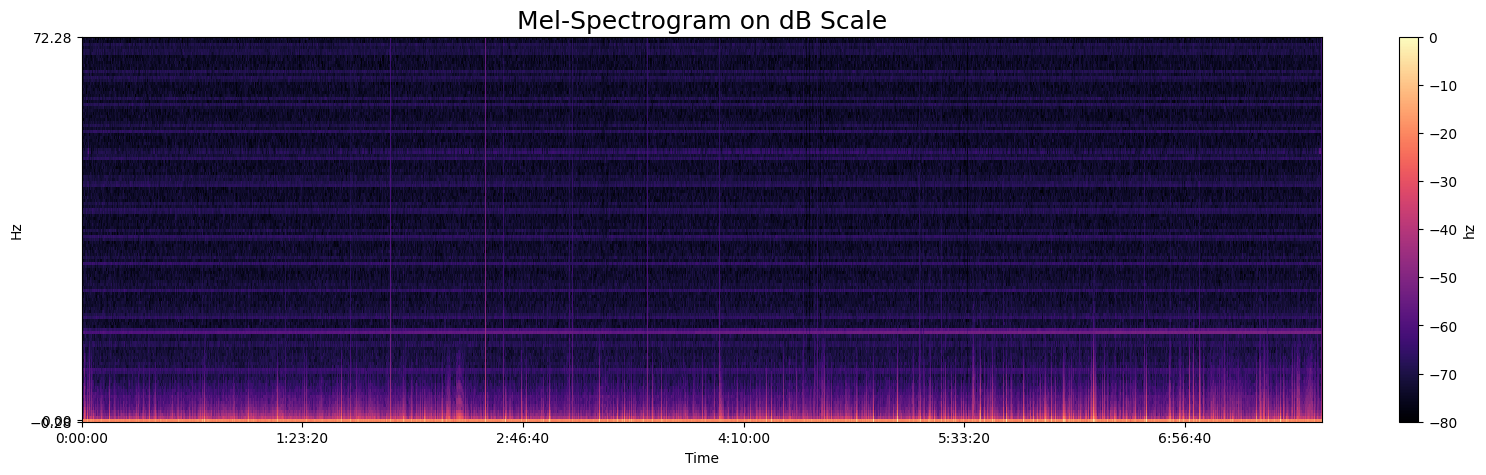

In [ ]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(merged_df["mel_spectrogram"][0], x_axis='time',
                         y_axis='mel', sr=144, cmap= "magma", hop_length=512)
plt.colorbar(label="hz")
plt.title('Mel-Spectrogram on dB Scale', fontdict=dict(size=18))
plt.show()

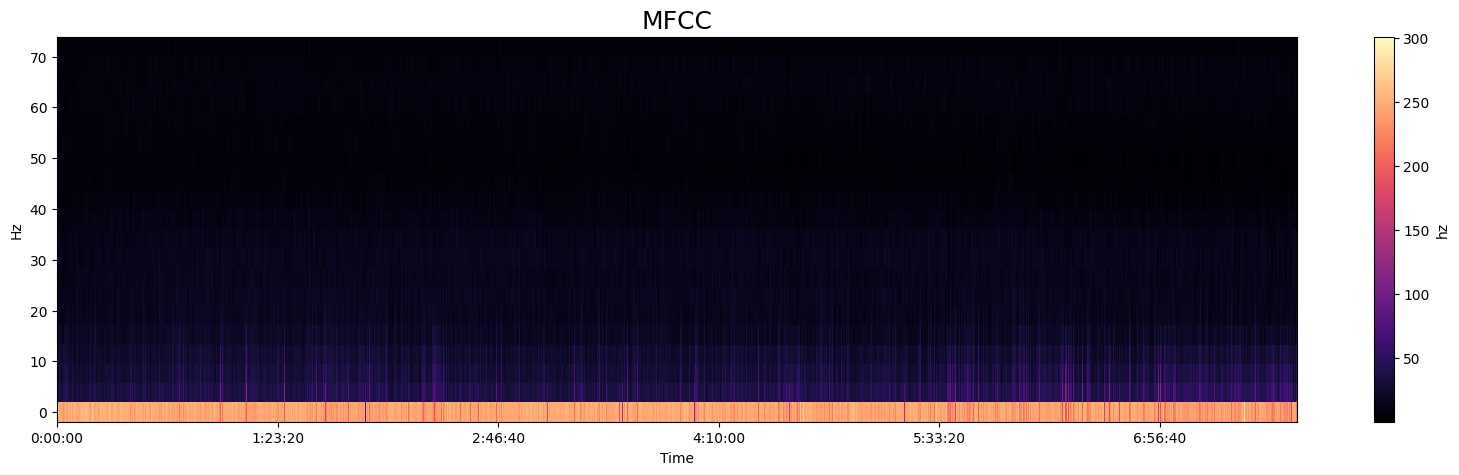

In [ ]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(np.abs(merged_df["mfcc"][0]), x_axis='time',
                         y_axis = "hz", sr=144, cmap= "magma")
plt.colorbar(label = "hz")
plt.title("MFCC", fontdict=dict(size=18))
plt.show()

We will also visualize the waveform to look at the peaks of amiplitudes (https://librosa.org/doc/main/generated/librosa.display.waveshow.html).

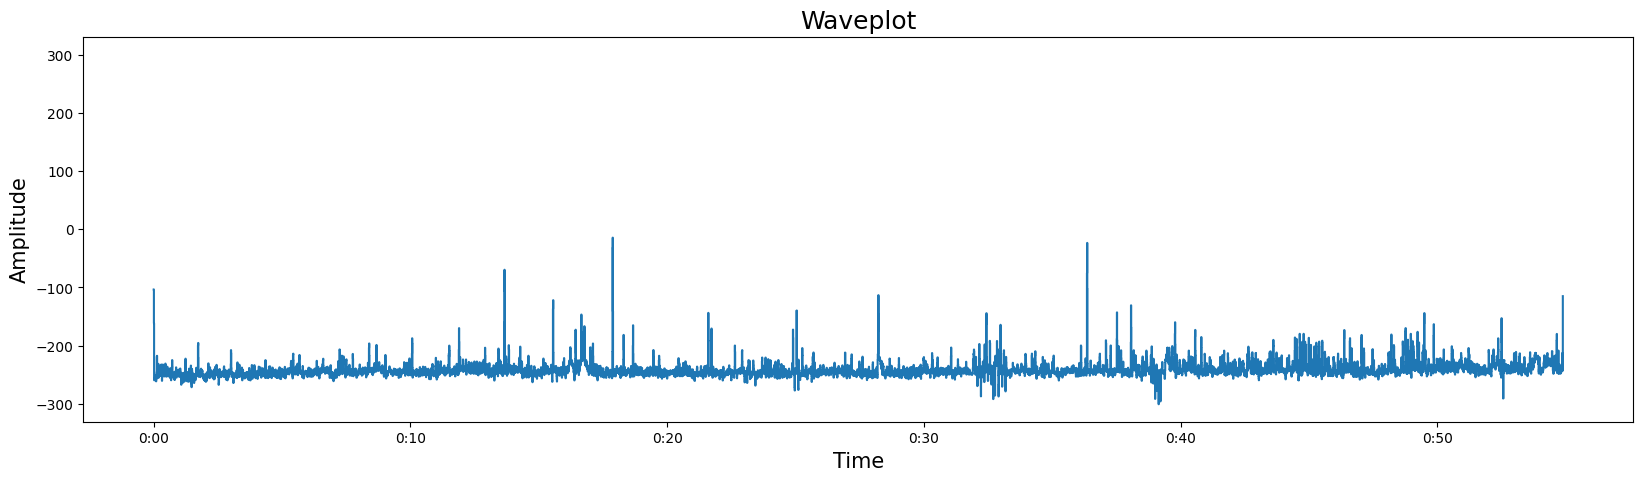

In [ ]:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(merged_df["mfcc"][0], sr = 144)
plt.title("Waveplot", fontdict=dict(size=18))
plt.xlabel("Time", fontdict=dict(size=15))
plt.ylabel("Amplitude", fontdict=dict(size=15))
plt.show()

## Training Image Classification Neural Networks

### Dataset

We create a custom Dataset object for the mfcc or the melspectrogram.

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, audio_data, labels, transform=None):
        self.audio_data = audio_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        # Load mel spectrogram
        mel_spectrogram = np.dstack([self.audio_data[idx], self.audio_data[idx], self.audio_data[idx]])

        # Apply transforms if specified
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)

        label = self.labels[idx]

        return mel_spectrogram, label

# Define transform to convert numpy arrays to torch tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384)),  # Match input size expected by the model
    transforms.Normalize(mean=[0.5], std=[0.5])
])

First we split the dataframe into train and validation set.

In [ ]:
train_df = merged_df.sample(frac=0.8, random_state=42)
val_df = merged_df.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [ ]:
train_df

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Window stop,Snore time,Weather temperature (°C),Weather type,Notes,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-31 03:00:00,2024-10-31 10:00:00,0.79,26133.0,23345.0,522.0,92%,False,0.0,0.688784,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 02:00:00,"[[-18.892347, -19.253256, -20.119987, -18.2465...","[[-114.934906, -160.91049, -212.936, -212.7094...",behrad_142Hz_1730341004221.wav,behrad
1,2024-11-12 23:00:00,2024-11-13 07:00:00,0.79,31771.0,26052.0,953.0,69%,False,0.0,0.566554,...,NaN,NaN,NaN,NaN,NaN,2024-11-12 22:00:00,"[[-0.28239822, -1.0420609, -2.447895, -2.41519...","[[-79.36574, -138.67812, -265.68372, -254.9208...",fynn_142Hz_1731448941993.wav,Fynn
2,2024-11-16 02:00:00,2024-11-16 10:00:00,0.63,26254.0,21266.0,1487.0,7%,False,0.0,0.137122,...,NaN,NaN,NaN,NaN,NaN,2024-11-16 01:00:00,"[[-19.61416, -20.31984, -18.795206, -13.579906...","[[-93.44319, -148.90176, -220.43121, -216.1947...",behrad_142Hz_1731721964748.wav,behrad
3,2024-10-24 03:00:00,2024-10-24 11:00:00,0.87,28383.0,24504.0,3879.0,93%,False,0.0,0.126836,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 01:00:00,"[[-18.845198, -19.083887, -20.093538, -20.2239...","[[-103.47621, -161.67538, -257.6723, -259.5341...",behrad_142Hz_1729733764243.wav,behrad
4,2024-11-07 00:00:00,2024-11-07 07:00:00,0.73,27220.7,25043.1,NaN,97%,False,NaN,NaN,...,NaN,0.0,0.0,No weather,NaN,2024-11-06 23:00:00,"[[-13.341015, -11.367334, -10.039801, -8.81894...","[[-159.16975, -174.52184, -207.57936, -195.099...",linus_142Hz_1730935108787.wav,linus
5,2024-11-24 23:00:00,2024-11-25 08:00:00,0.89,30971.0,23950.0,929.0,99%,False,0.0,0.348713,...,NaN,NaN,NaN,NaN,NaN,2024-11-24 22:00:00,"[[-0.27672768, -1.0056992, -2.4110184, -2.4399...","[[-78.57607, -137.97098, -267.29535, -284.7872...",fynn_142Hz_1732487181377.wav,Fynn
6,2024-11-07 03:00:00,2024-11-07 11:00:00,0.88,29561.0,22959.0,591.0,70%,False,0.0,0.974257,...,NaN,NaN,NaN,NaN,NaN,2024-11-07 01:00:00,"[[-15.632172, -15.477303, -17.112309, -18.6281...","[[-62.880783, -110.70234, -154.03633, -219.532...",behrad_07-11-2024_02_51_09_142Hz_1730944269321...,behrad
7,2024-11-15 01:00:00,2024-11-15 07:00:00,0.50,23076.2,19922.4,NaN,91%,True,NaN,NaN,...,NaN,3172.4,0.0,No weather,NaN,2024-11-14 23:00:00,"[[-10.690563, -11.561344, -13.176523, -13.3738...","[[-147.1095, -153.98924, -167.7995, -157.04924...",linus_142Hz_1731627171218.wav,linus
8,2024-11-10 03:00:00,2024-11-10 10:00:00,0.71,24828.0,19366.0,2317.0,95%,False,0.0,0.434993,...,NaN,NaN,NaN,NaN,NaN,2024-11-10 02:00:00,"[[3.8146973e-06, -1.6108208, -13.502918, -23.9...","[[130.01466, 62.54068, -222.61348, -224.39777,...",behrad_142Hz_1731205560774.wav,behrad
9,2024-10-30 23:00:00,2024-10-31 07:00:00,0.81,28738.0,25193.0,957.0,91%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-30 22:00:00,"[[-0.3088112, -1.0602779, -2.45961, -2.4404087...","[[-79.32655, -140.82568, -275.975, -271.65118,...",fynn_142Hz_1730326147804.wav,Fynn


In [ ]:
val_df

,Went to bed,Woke up,Sleep Quality,Time in bed (seconds),Time asleep (seconds),Asleep after (seconds),Regularity,Did snore,Snore time (seconds),Coughing (per hour),...,Window stop,Snore time,Weather temperature (°C),Weather type,Notes,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-26 03:00:00,2024-10-26 10:00:00,0.77,26815.0,24312.0,1877.0,90%,False,0.0,0.671266,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 01:00:00,"[[-9.23892, -9.857187, -11.167709, -11.00028, ...","[[-103.45986, -161.75743, -261.34668, -251.597...",behrad_142Hz_1729904937567.wav,behrad
1,2024-10-27 03:00:00,2024-10-27 11:00:00,0.74,30190.0,25460.0,603.0,83%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 02:00:00,"[[-18.04505, -18.773344, -20.911755, -21.46679...","[[-78.52124, -138.69447, -247.02243, -231.1913...",behrad_142Hz_1729994749595.wav,behrad
2,2024-11-12 02:00:00,2024-11-12 10:00:00,0.76,29456.0,23270.0,883.0,94%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-11-12 01:00:00,"[[-0.30748177, -1.0524445, -2.4731674, -2.5889...","[[-85.96827, -144.30675, -240.32425, -253.3274...",behrad_142Hz_1731375736354.wav,behrad
3,2024-11-18 02:00:00,2024-11-18 09:00:00,0.68,22987.0,18389.0,2835.0,83%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-11-18 01:00:00,"[[-18.62088, -19.09333, -19.112982, -19.748749...","[[-90.48881, -150.84868, -246.84933, -254.7042...",behrad_142Hz_1731894532622.wav,behrad
4,2024-10-24 00:00:00,2024-10-24 08:00:00,0.86,28483.7,24875.8,NaN,91%,True,NaN,NaN,...,2024-10-24 08:30:00,445.6,0.0,No weather,NaN,2024-10-23 22:00:00,"[[1.9073486e-06, -0.7811718, -2.1136894, -2.04...","[[-76.456566, -123.06618, -205.4203, -195.6450...",linus_142Hz_1729721787072.wav,linus
5,2024-10-30 00:00:00,2024-10-30 07:00:00,0.78,25513.1,21175.9,NaN,84%,True,NaN,NaN,...,NaN,930.0,0.0,No weather,NaN,2024-10-29 23:00:00,"[[-1.3402023, -2.0798512, -3.4581966, -3.50234...","[[-76.878784, -120.77661, -177.9117, -171.7848...",linus_142Hz_1730244394101.wav,linus
6,2024-11-07 23:00:00,2024-11-08 07:00:00,0.83,29369.4,25257.7,NaN,94%,True,NaN,NaN,...,NaN,1473.2,0.0,No weather,NaN,2024-11-07 22:00:00,"[[-8.066786, -8.868265, -6.52845, -3.7007828, ...","[[-108.28917, -153.09918, -193.91762, -192.993...",linus_142Hz_1731018124056.wav,linus
7,2024-11-18 23:00:00,2024-11-19 07:00:00,0.91,29540.8,23435.7,NaN,80%,True,NaN,NaN,...,NaN,3063.1,0.0,No weather,NaN,2024-11-18 22:00:00,"[[-13.606913, -14.516317, -15.968542, -15.7361...","[[-162.04842, -184.4609, -190.79799, -161.0578...",linus_142Hz_1731968621195.wav,linus
8,2024-11-13 00:00:00,2024-11-13 08:00:00,0.85,29604.9,24374.7,NaN,86%,True,NaN,NaN,...,2024-11-13 08:40:00,0.0,0.0,No weather,NaN,2024-11-12 23:00:00,"[[-9.500118, -7.8472214, -14.609394, -17.41272...","[[-124.78043, -83.16382, -130.0361, -199.66444...",Jasper_142Hz_1731453980627.wav,Jasper
9,2024-10-24 23:00:00,2024-10-25 08:00:00,0.97,31947.0,28326.0,638.0,47%,False,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 21:00:00,"[[-19.221127, -17.192738, -13.734734, -16.4358...","[[-118.49912, -158.36926, -198.66982, -192.644...",fynn_142Hz_1729804896397.wav,Fynn


Furthermore, we check if the training and validation set contain the same data entries.

In [ ]:
train_df.merge(val_df, on=["filenames", "Sleep Quality"], how = "inner")

,Went to bed_x,Woke up_x,Sleep Quality,Time in bed (seconds)_x,Time asleep (seconds)_x,Asleep after (seconds)_x,Regularity_x,Did snore_x,Snore time (seconds)_x,Coughing (per hour)_x,...,Window start_y,Window stop_y,Snore time_y,Weather temperature (°C)_y,Weather type_y,Notes_y,timestamp_y,mel_spectrogram_y,mfcc_y,subset_y


We create the corresponding dataset and dataloader object.

In [ ]:
# Instantiate the dataset
dataset_train = AudioDataset(audio_data=train_df["mfcc"], labels=train_df["Sleep Quality"], transform=transform)
dataset_val = AudioDataset(audio_data=val_df["mfcc"], labels=val_df["Sleep Quality"], transform=transform)

# Create a DataLoader
data_loader = DataLoader(dataset_train, batch_size=4, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)

In [ ]:
# Load a pretrained model from timm

model = timm.create_model('vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k', pretrained=True)
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

It is important to note that we are doing a regression task, therefore we need to change the last layer to have only one output feature.

### Model loading and training

In [ ]:
# Modify the model's classifier for regression
num_ftrs = model.head.in_features
# Modify the last layer for regression
model.head = nn.Linear(num_ftrs, 1)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR

def get_warmup_scheduler(optimizer, num_warmup_steps, total_steps):
    """
    Returns a scheduler with a linear warmup phase.

    :param optimizer: Optimizer to adjust the learning rate for.
    :param num_warmup_steps: Number of steps for the warmup phase.
    :param total_steps: Total number of training steps.
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - num_warmup_steps)))

    return LambdaLR(optimizer, lr_lambda)

In [ ]:
# Define warmup and total steps
num_epochs = 10
total_steps = len(data_loader) * num_epochs
warmup_ratio = 0.1
num_warmup_steps = int(warmup_ratio * total_steps)

In [ ]:
# Define loss and optimizer
criterion = nn.HuberLoss(reduction='mean', delta=0.25)
#criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
# Set number of epochs
epochs = 5*3

step_size = 3
gamma = 0.5

# Create scheduler
scheduler = get_warmup_scheduler(optimizer, num_warmup_steps, total_steps)

# Scheduler
#scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    val_loss = 0.0

    # Iterate over the training data
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze()  # Get predictions
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # Step scheduler
        scheduler.step()
    #scheduler.step()
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in data_loader_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

    # Print the losses for this epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss / len(data_loader)}, Validation Loss: {val_loss / len(data_loader_val)}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Epoch 1/15, Train Loss: 0.4181040316820145, Validation Loss: 0.33710491567035206
Epoch 2/15, Train Loss: 0.15858947231123846, Validation Loss: 0.08640489267806212
Epoch 3/15, Train Loss: 0.06457070857286454, Validation Loss: 0.011802502296541206
Epoch 4/15, Train Loss: 0.04448788482695818, Validation Loss: 0.025276172505861418
Epoch 5/15, Train Loss: 0.034224170508484045, Validation Loss: 0.04875268600892847
Epoch 6/15, Train Loss: 0.026011408865451814, Validation Loss: 0.01747212186928664
Epoch 7/15, Train Loss: 0.017905286295960346, Validation Loss: 0.015586552569584456
Epoch 8/15, Train Loss: 0.014305228367447853, Validation Loss: 0.012577726402863238
Epoch 9/15, Train Loss: 0.016170358347396056, Validation Loss: 0.0045672088000477135
Epoch 10/15, Train Loss: 0.01157735960247616, Validation Loss: 0.003145196667242563
Epoch 11/15, Train Loss: 0.008125612403576572, Validation Loss: 0.003145196667242563
Epoch 12/15, Train Loss: 0.008125612403576572, Validation Loss: 0.00314519666724256

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Perform inference
predictions = []
with torch.no_grad():  # Disable gradient computation for inference
    for inputs, labels in data_loader_val:
        # Move data to device
        mel_spectrogram = inputs.to(device)

        # Forward pass
        output = model(mel_spectrogram)

        # Store the prediction
        predictions.append((output.item(), labels))  # Convert to Python number

# Print the predictions
for i, pred in enumerate(predictions):
    print(f"Prediction for audio {i}: {pred[0]}  Actual value for audio {i}: {pred[1].item()}")

Prediction for audio 0: 0.7252895832061768  Actual value for audio 0: 0.77
Prediction for audio 1: 0.6962977051734924  Actual value for audio 1: 0.74
Prediction for audio 2: 0.74200040102005  Actual value for audio 2: 0.76
Prediction for audio 3: 0.7111990451812744  Actual value for audio 3: 0.68
Prediction for audio 4: 0.8530349135398865  Actual value for audio 4: 0.86
Prediction for audio 5: 0.8663017153739929  Actual value for audio 5: 0.78
Prediction for audio 6: 0.8695940375328064  Actual value for audio 6: 0.83
Prediction for audio 7: 0.8727723360061646  Actual value for audio 7: 0.91
Prediction for audio 8: 0.820101261138916  Actual value for audio 8: 0.85
Prediction for audio 9: 0.767134964466095  Actual value for audio 9: 0.97
Prediction for audio 10: 0.819934070110321  Actual value for audio 10: 0.82
Prediction for audio 11: 0.7599729299545288  Actual value for audio 11: 0.59
Prediction for audio 12: 0.8045051693916321  Actual value for audio 12: 0.74
Prediction for audio 13:

In [ ]:
from sklearn.metrics import r2_score



# Separate the predicted and true values
predicted, true = zip(*predictions)

# Compute the R² score
r2 = r2_score(true, predicted)

print("R² Score:", r2)

R² Score: 0.2592179853077926
